In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from tqdm import tqdm
from keras import backend as K
from random import shuffle
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
import os
import cv2
from keras.models import load_model

C:\Users\lenovo-pc\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
original_dim = 4096
intermediate_dim = 512
latent_dim = 2
batch_size = 256
epochs = 100
epsilon_std = 1.0

In [4]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [5]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

In [6]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


In [7]:
import os
import cv2 
datadir = "E:\image1"
training_data = []
for img in tqdm(os.listdir(datadir)):
    
    path = os.path.join(datadir,img)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64,64))
    training_data.append([np.array(img)])
shuffle(training_data)
np.save('train_data.npy', training_data)
split = 0.7
ind = math.floor(split * len(training_data))
train = training_data[-ind:]
test = training_data[ind:]
print(len(train),len(test))



100%|██████████████████████████████████████████████████████████████████████████████| 5072/5072 [01:23<00:00, 60.95it/s]


3550 1522


In [8]:
X = np.array([i[0] for i in train]).reshape(-1,64*64)/255.
print(X.shape)
test_x = np.array([i[0] for i in test]).reshape(-1,64*64)/255.

(3550, 4096)


In [11]:

vae.fit(X,
        X,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_x, test_x))

yay
Train on 3550 samples, validate on 1522 samples
Epoch 1/100
3550/3550 [==============================] - ETA: 6s - loss: 2794.65 - ETA: 6s - loss: 2798.64 - ETA: 5s - loss: 2796.30 - ETA: 4s - loss: 2806.76 - ETA: 4s - loss: 2803.69 - ETA: 3s - loss: 2796.69 - ETA: 3s - loss: 2804.34 - ETA: 3s - loss: 2815.52 - ETA: 2s - loss: 2812.06 - ETA: 2s - loss: 2804.00 - ETA: 1s - loss: 2798.80 - ETA: 0s - loss: 2792.87 - ETA: 0s - loss: 2793.19 - 9s 2ms/step - loss: 2787.5800 - val_loss: 2673.1339
Epoch 2/100
3550/3550 [==============================] - ETA: 7s - loss: 2674.40 - ETA: 5s - loss: 2674.15 - ETA: 5s - loss: 2712.22 - ETA: 5s - loss: 2685.98 - ETA: 4s - loss: 2666.58 - ETA: 4s - loss: 2657.75 - ETA: 3s - loss: 2658.52 - ETA: 3s - loss: 2656.12 - ETA: 2s - loss: 2663.05 - ETA: 1s - loss: 2712.99 - ETA: 1s - loss: 2712.73 - ETA: 0s - loss: 2704.36 - ETA: 0s - loss: 2696.21 - 8s 2ms/step - loss: 2692.5835 - val_loss: 2721.8478
Epoch 3/100
3550/3550 [==============================]

3550/3550 [==============================] - ETA: 6s - loss: 2504.45 - ETA: 5s - loss: 2508.47 - ETA: 5s - loss: 2514.46 - ETA: 5s - loss: 2514.12 - ETA: 4s - loss: 2516.46 - ETA: 4s - loss: 2515.39 - ETA: 3s - loss: 2514.41 - ETA: 3s - loss: 2524.22 - ETA: 2s - loss: 2524.68 - ETA: 2s - loss: 2522.69 - ETA: 1s - loss: 2521.68 - ETA: 1s - loss: 2519.21 - ETA: 0s - loss: 2518.26 - 9s 3ms/step - loss: 2519.2444 - val_loss: 2529.7644
Epoch 20/100
3550/3550 [==============================] - ETA: 6s - loss: 2559.91 - ETA: 5s - loss: 2556.90 - ETA: 5s - loss: 2541.70 - ETA: 4s - loss: 2540.02 - ETA: 4s - loss: 2530.84 - ETA: 3s - loss: 2534.25 - ETA: 3s - loss: 2528.26 - ETA: 2s - loss: 2525.54 - ETA: 2s - loss: 2523.88 - ETA: 1s - loss: 2522.04 - ETA: 1s - loss: 2520.24 - ETA: 0s - loss: 2519.81 - ETA: 0s - loss: 2518.07 - 9s 2ms/step - loss: 2517.7134 - val_loss: 2538.1273
Epoch 21/100
3550/3550 [==============================] - ETA: 7s - loss: 2529.45 - ETA: 6s - loss: 2526.32 - ETA: 5s

3550/3550 [==============================] - ETA: 6s - loss: 2468.78 - ETA: 5s - loss: 2477.63 - ETA: 5s - loss: 2474.14 - ETA: 4s - loss: 2469.55 - ETA: 4s - loss: 2469.89 - ETA: 3s - loss: 2465.94 - ETA: 3s - loss: 2468.44 - ETA: 2s - loss: 2469.27 - ETA: 2s - loss: 2473.36 - ETA: 1s - loss: 2474.37 - ETA: 1s - loss: 2475.88 - ETA: 0s - loss: 2474.03 - ETA: 0s - loss: 2476.78 - 8s 2ms/step - loss: 2478.8934 - val_loss: 2532.8328
Epoch 38/100
3550/3550 [==============================] - ETA: 6s - loss: 2515.21 - ETA: 6s - loss: 2501.62 - ETA: 5s - loss: 2500.78 - ETA: 4s - loss: 2506.29 - ETA: 4s - loss: 2502.10 - ETA: 3s - loss: 2497.55 - ETA: 3s - loss: 2492.43 - ETA: 2s - loss: 2492.46 - ETA: 2s - loss: 2486.53 - ETA: 1s - loss: 2486.62 - ETA: 1s - loss: 2484.19 - ETA: 0s - loss: 2483.59 - ETA: 0s - loss: 2482.76 - 8s 2ms/step - loss: 2482.8648 - val_loss: 2481.0186
Epoch 39/100
3550/3550 [==============================] - ETA: 6s - loss: 2500.72 - ETA: 6s - loss: 2485.24 - ETA: 5s

3550/3550 [==============================] - ETA: 7s - loss: 2474.00 - ETA: 6s - loss: 2473.30 - ETA: 5s - loss: 2464.67 - ETA: 5s - loss: 2468.66 - ETA: 4s - loss: 2469.37 - ETA: 4s - loss: 2473.09 - ETA: 3s - loss: 2466.29 - ETA: 2s - loss: 2466.87 - ETA: 2s - loss: 2467.78 - ETA: 1s - loss: 2469.60 - ETA: 1s - loss: 2473.24 - ETA: 0s - loss: 2475.20 - ETA: 0s - loss: 2470.94 - 8s 2ms/step - loss: 2471.3284 - val_loss: 2463.2773
Epoch 56/100
3550/3550 [==============================] - ETA: 6s - loss: 2440.56 - ETA: 6s - loss: 2460.89 - ETA: 5s - loss: 2460.27 - ETA: 5s - loss: 2462.55 - ETA: 4s - loss: 2467.42 - ETA: 4s - loss: 2469.44 - ETA: 3s - loss: 2470.40 - ETA: 2s - loss: 2472.66 - ETA: 2s - loss: 2473.71 - ETA: 1s - loss: 2472.36 - ETA: 1s - loss: 2470.32 - ETA: 0s - loss: 2466.95 - ETA: 0s - loss: 2467.43 - 8s 2ms/step - loss: 2468.3526 - val_loss: 2466.6205
Epoch 57/100
3550/3550 [==============================] - ETA: 5s - loss: 2472.00 - ETA: 5s - loss: 2464.19 - ETA: 5s

3550/3550 [==============================] - ETA: 7s - loss: 2448.33 - ETA: 6s - loss: 2452.69 - ETA: 5s - loss: 2464.28 - ETA: 5s - loss: 2476.28 - ETA: 4s - loss: 2467.50 - ETA: 4s - loss: 2457.89 - ETA: 3s - loss: 2451.75 - ETA: 3s - loss: 2450.78 - ETA: 2s - loss: 2451.07 - ETA: 1s - loss: 2452.51 - ETA: 1s - loss: 2453.20 - ETA: 0s - loss: 2452.66 - ETA: 0s - loss: 2453.61 - 8s 2ms/step - loss: 2455.2707 - val_loss: 2463.0005
Epoch 74/100
3550/3550 [==============================] - ETA: 6s - loss: 2487.86 - ETA: 6s - loss: 2487.96 - ETA: 5s - loss: 2476.81 - ETA: 5s - loss: 2469.65 - ETA: 4s - loss: 2462.35 - ETA: 4s - loss: 2468.95 - ETA: 3s - loss: 2462.79 - ETA: 3s - loss: 2460.13 - ETA: 2s - loss: 2459.65 - ETA: 1s - loss: 2459.10 - ETA: 1s - loss: 2462.46 - ETA: 0s - loss: 2462.50 - ETA: 0s - loss: 2460.68 - 8s 2ms/step - loss: 2460.6209 - val_loss: 2458.1919
Epoch 75/100
3550/3550 [==============================] - ETA: 5s - loss: 2470.63 - ETA: 5s - loss: 2463.24 - ETA: 5s

3550/3550 [==============================] - ETA: 6s - loss: 2467.81 - ETA: 6s - loss: 2487.44 - ETA: 5s - loss: 2473.13 - ETA: 4s - loss: 2458.84 - ETA: 4s - loss: 2455.30 - ETA: 4s - loss: 2455.13 - ETA: 3s - loss: 2454.21 - ETA: 2s - loss: 2451.22 - ETA: 2s - loss: 2447.76 - ETA: 1s - loss: 2450.21 - ETA: 1s - loss: 2453.29 - ETA: 0s - loss: 2453.44 - ETA: 0s - loss: 2452.97 - 8s 2ms/step - loss: 2452.2979 - val_loss: 2457.6513
Epoch 92/100
3550/3550 [==============================] - ETA: 6s - loss: 2457.47 - ETA: 6s - loss: 2456.34 - ETA: 5s - loss: 2449.77 - ETA: 5s - loss: 2451.57 - ETA: 4s - loss: 2449.43 - ETA: 4s - loss: 2452.86 - ETA: 3s - loss: 2447.23 - ETA: 2s - loss: 2449.20 - ETA: 2s - loss: 2448.50 - ETA: 1s - loss: 2449.19 - ETA: 1s - loss: 2448.88 - ETA: 0s - loss: 2449.09 - ETA: 0s - loss: 2446.93 - 8s 2ms/step - loss: 2451.2115 - val_loss: 2459.0336
Epoch 93/100
3550/3550 [==============================] - ETA: 6s - loss: 2441.38 - ETA: 6s - loss: 2459.37 - ETA: 5s

In [12]:
vae.save_weights('vae_face_64_300.h5')

In [13]:
encoder = Model(x, z_mu)

In [14]:
z_test = encoder.predict(test_x, batch_size=batch_size)

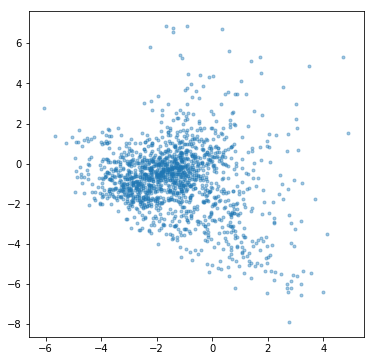

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1],
            alpha=.4, s=3**2, cmap='viridis')

plt.show()

In [22]:
n = 24
digit_size = 64

In [23]:
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

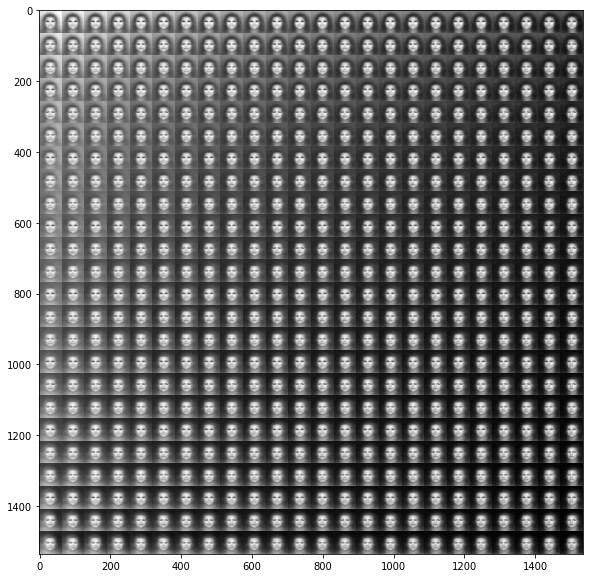

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

In [25]:
n = 15  # figure with 10x10 faces
face_size = 64
#figure = np.zeros((face_size * n, face_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian

# change values below to generate new images
grid_x = np.linspace(-10, 10, 5)
grid_y = np.linspace(-10, 10, n)

# code to create a result.png with generated faces
plt.figure(figsize=(10, 5))
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[yi, xi]])
        x_decoded = decoder.predict(z_sample)
        x_decoded = x_decoded
        #print x_decoded.shape
        face = x_decoded[0].reshape(face_size, face_size)
        ax = plt.subplot(5, 15, (i*15)+j+1)
        plt.imshow(face,cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig('result1.png')